<b>Contexto:</b>

Desenvolver uma análise utilizando a metodologia CRISP-DM, confrontar métricas de problemas de classificação para fins de comparação da performance entre modelos de previsão baseados em arvorê de decisão, utilizando diferentes técnicas de preparação de dados com o intuito de prever transações fraudulentas em uma instituição financeira.

In [1]:
#Bibliotecas 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb  #pip install xgboost
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
#Leitura dos dados

df = pd.read_csv('Fraud.csv')

### DATA UNDERSTANDING 

<b>Data Dictionary:</b>

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [4]:
df.shape

(6362620, 11)

In [5]:
df.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4857456,348,CASH_OUT,340846.45,C1589875807,1055.00,0.00,C1592912196,105861.82,446708.27,0,0
6166048,551,CASH_IN,54741.53,C1752698594,3889282.56,3944024.09,C79337380,2767241.35,2712499.82,0,0
4994985,352,CASH_OUT,233485.20,C312194612,0.00,0.00,C1312736521,3387579.80,3621065.01,0,0
4211347,305,TRANSFER,909478.68,C1960882421,0.00,0.00,C1326706032,20000000.00,20909478.68,0,0
434765,18,PAYMENT,3747.37,C1232444262,127424.31,123676.94,M749467313,0.00,0.00,0,0
4053959,300,CASH_IN,296094.73,C236540496,3453359.41,3749454.14,C839625049,2113510.95,1817416.22,0,0
6043518,490,CASH_IN,182854.90,C1554845208,2278571.31,2461426.21,C460234161,629657.10,446802.20,0,0
5447625,379,CASH_IN,90442.31,C1784724587,701665.95,792108.25,C1235245848,126905.39,36463.09,0,0
1083883,129,CASH_OUT,388193.88,C591499075,140625.00,0.00,C2126755176,104435.03,492628.91,0,0
6244188,595,CASH_IN,291794.51,C469776035,4091549.87,4383344.37,C263124,16471691.72,16179897.22,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Obs: Dataset sem valores nulos

<AxesSubplot:>

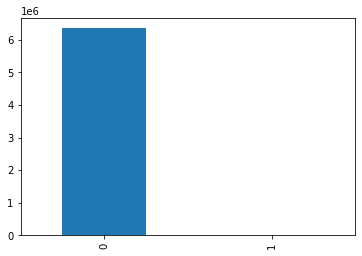

In [8]:
df['isFraud'].value_counts().plot(kind="bar")

In [9]:
nfraude = len(df[df.isFraud == 0])
fraude = len(df[df.isFraud == 1])

print("Num. de transações legítimas: ", nfraude)
print("Num. de transações fraudulentas: ", fraude)
print("% de transações legítimas: {:.4f} %".format((nfraude / (fraude + nfraude)) * 100))
print("% de transações fraudulentas: {:.4f} %".format((fraude / (fraude + nfraude)) * 100))

Num. de transações legítimas:  6354407
Num. de transações fraudulentas:  8213
% de transações legítimas: 99.8709 %
% de transações fraudulentas: 0.1291 %


Obs: Target desbalanceada

<AxesSubplot:>

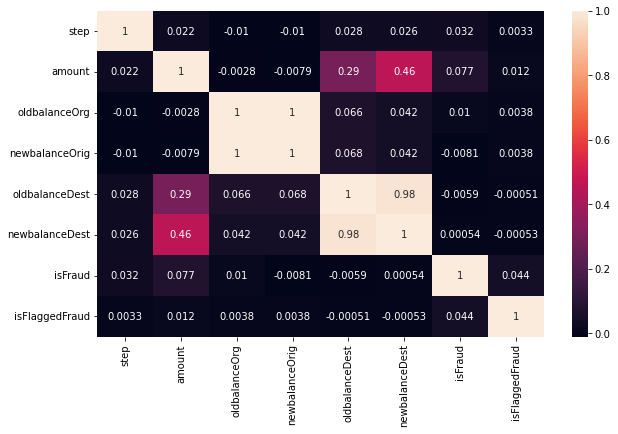

In [10]:
#Verificação de correlação

correlacao = df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlacao, annot=True)

Obs: Correlação forte entre "oldbalanceOrg" e "newbalanceOrig" / "newbalanceDest" e "oldbalanceDest" 

#### FEATURE 'amount' 'oldbalanceOrg' 'newbalanceOrig' 'oldbalanceDest' 'newbalanceDest

In [11]:
#Features quantitativas sem filtros

df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,179861.90,833883.10,855113.67,1100701.67,1224996.40
std,603858.23,2888242.67,2924048.50,3399180.11,3674128.94
min,0.00,0.00,0.00,0.00,0.00
25%,13389.57,0.00,0.00,0.00,0.00
50%,74871.94,14208.00,0.00,132705.66,214661.44
75%,208721.48,107315.18,144258.41,943036.71,1111909.25
max,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92


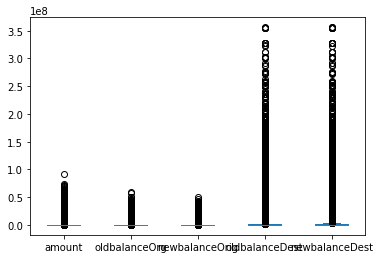

In [12]:
ax = df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].plot(kind='box')
plt.show()

Obs: Presença de outliers em todas as features

In [13]:
#Features quantitativas filtro: "nameDest" = merchants 

merchants = df[df['nameDest'].str.contains('M')]
merchants[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,2151495.00,2151495.00,2151495.00,2151495.00,2151495.00
mean,13057.60,68216.83,61837.89,0.00,0.00
std,12556.45,198991.08,196991.52,0.00,0.00
min,0.02,0.00,0.00,0.00,0.00
25%,4383.82,0.00,0.00,0.00,0.00
50%,9482.19,10530.00,0.00,0.00,0.00
75%,17561.22,60883.00,49654.13,0.00,0.00
max,238637.98,43686616.33,43673802.21,0.00,0.00


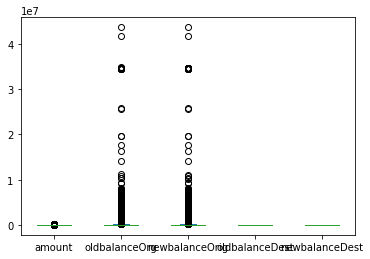

In [14]:
ax = merchants[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].plot(kind='box')
plt.show()

Obs: Conforme descrito no dicionário, "nameDest" descritos como comerciantes não possuem dados de "oldbalanceDest" e "newbalanceDest". Notei também uma diminuição no desvio padrão e na presença de outliers na feature "amount". Bem como diminuição do desvio padrão para as features "oldbalanceOrg" e "newbalanceOrig"

In [15]:
#Features quantitativas filtro: "nameDest" = merchants e "isFraud" = 1
 
merchantsF = df[(df['nameDest'].str.contains('M')) & (df['isFraud'] == 1)]
merchantsF[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,0.00,0.00,0.00,0.00,0.00
mean,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN


Obs: Não existem registros de transações envolvendo comerciantes classificadas como fraude

In [16]:
#Features quantitativas filtro: "nameDest" != merchants

nmerchants = df[~df['nameDest'].str.contains('M')]
nmerchants[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,4211125.00,4211125.00,4211125.00,4211125.00,4211125.00
mean,265083.46,1225067.68,1260404.15,1663058.31,1850856.14
std,727589.12,3482978.00,3523174.12,4064779.99,4386080.47
min,0.00,0.00,0.00,0.00,0.00
25%,76085.56,0.00,0.00,139659.05,221717.59
50%,158943.21,18155.00,0.00,551247.21,683724.79
75%,278485.01,191127.82,284954.41,1692950.88,1910978.53
max,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92


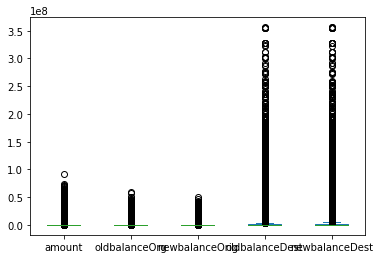

In [17]:
ax = nmerchants[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].plot(kind='box')
plt.show()

Obs: Presença de outliers em todas a features

In [18]:
#Features quantitativas filtro: "nameDest" != merchants e "isFraud" = 1

nmerchantsF = df[(~df['nameDest'].str.contains('M')) & (df['isFraud'] == 1)]
nmerchantsF[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,8213.00,8213.00,8213.00,8213.00,8213.00
mean,1467967.30,1649667.61,192392.63,544249.62,1279707.62
std,2404252.95,3547719.44,1965666.46,3336420.95,3908816.53
min,0.00,0.00,0.00,0.00,0.00
25%,127091.33,125822.44,0.00,0.00,0.00
50%,441423.44,438983.45,0.00,0.00,4676.42
75%,1517771.48,1517771.48,0.00,147828.66,1058725.22
max,10000000.00,59585040.37,49585040.37,236230516.82,236726494.66


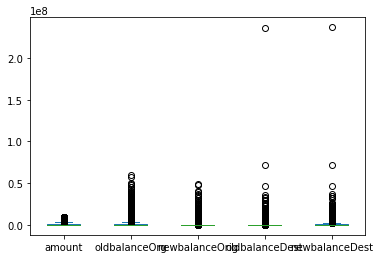

In [19]:
ax = nmerchantsF[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']].plot(kind='box')
plt.show()

Obs: Aumento considerável no desvio padrão da feature "amount"

#### FEATURE 'step'

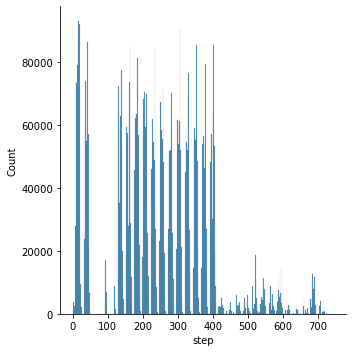

In [20]:
#Distribuição feature "step"

sns.displot(df['step'])

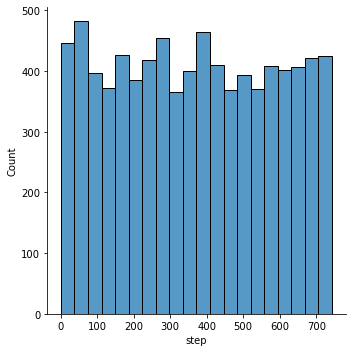

In [21]:
#Distribuição feature "step" para transações classificadas como fraude

sns.displot(df['step'].loc[df['isFraud'] == 1])  

Obs: Distribuição homogênea para transações classificadas como fraude

#### FEATURE 'type'

In [22]:
print(df['type'].value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


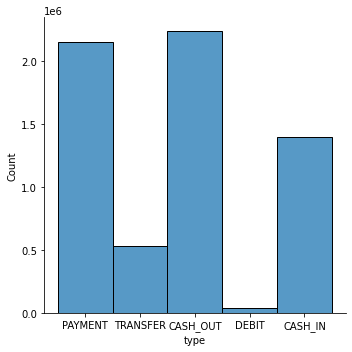

In [23]:
#Distribuição feature "type"

sns.displot(df['type'])

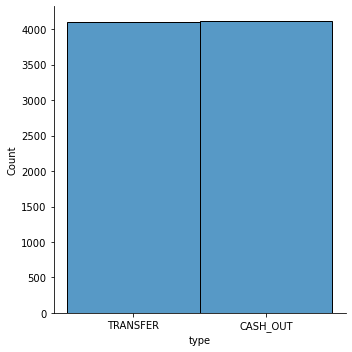

In [24]:
#Distribuição feature "type" para transações classificadas como fraude

sns.displot(df['type'].loc[df['isFraud'] == 1])  

Obs: Concentração das fraudes nos tipos "transfer" e "cash_out", distribuição homogênea entre ambas

#### FEATURE 'isFlaggedFraud'

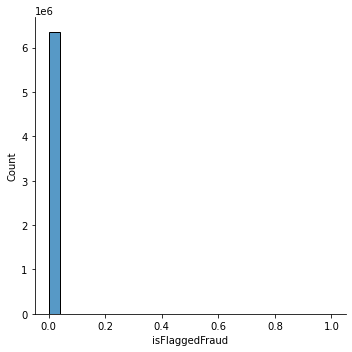

In [25]:
#Distribuição feature "isFlaggedFraud"

sns.displot(df['isFlaggedFraud'])

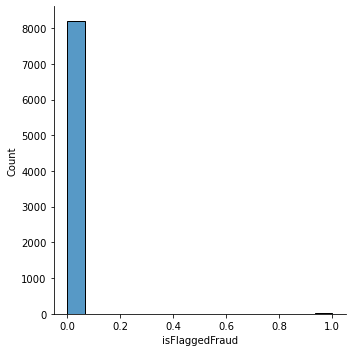

In [26]:
#Distribuição feature "isFlaggedFraud" classificadas como fraude

sns.displot(df['isFlaggedFraud'].loc[df['isFraud'] == 1]) 

In [27]:
#Transações com valor superior a 200 mil

df['amount'].loc[df['amount'] >= 200000.00].count()

1673570

In [28]:
#Transações classificadas como ilegais

df['isFlaggedFraud'].loc[df['isFlaggedFraud'] == 1].count()

16

In [29]:
#Transações com valor superior a 200 mil e classificadas como ilegais

df['amount'].loc[(df['amount'] >= 200000.00) & (df['isFlaggedFraud'] == 1)].count()

16

In [30]:
#Transações com valor superior a 200 mil, classificadas como ilegais e classificadas como fraude

flageed = df['amount'].loc[(df['amount'] >= 200000.00) & (df['isFlaggedFraud'] == 1) & (df['isFraud'] == 1)].count()
print(flageed)

16


In [31]:
print("{:.2f} %".format((flageed / fraude) * 100)) 

0.19 %


Obs: Apesar de um percentual baixo em relação ao conjunto de transações classificadas como fraude, 100% das transações classificadas como ilegais se mostraram fraudulentas

#### FEATURE 'nameOrig' 'nameDest'

In [32]:
nameOrig = pd.Series(df['nameOrig'].tolist())

print('Número de nameOrig únicos:',np.unique(nameOrig).shape[0])

n = nameOrig.value_counts() > 1
print('Número de nameOrig repetidos:',n[n].shape[0])

Número de nameOrig únicos: 6353307
Número de nameOrig repetidos: 9298


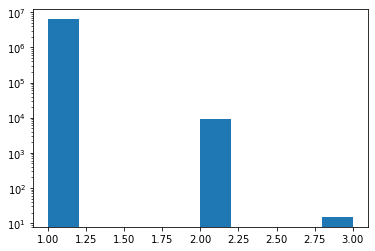

In [33]:
#Distribuição repetição feature "nameOrig"

plt.hist(nameOrig.value_counts().values)
plt.yscale('log')
plt.show()

In [34]:
#Feature "nameOrig" classificadas como fraude

nameOrigF = pd.Series(df['nameOrig'].loc[df['isFraud'] == 1].tolist())

print('Número de nameOrig únicos - Fraude : ',np.unique(nameOrigF).shape[0])

n = nameOrigF.value_counts() > 1
print('Número de nameOrig repetidos - Fraude : ',n[n].shape[0])

Número de nameOrig únicos - Fraude :  8213
Número de nameOrig repetidos - Fraude :  0


In [35]:
nameDest = pd.Series(df['nameDest'].tolist())

print('Número de nameDest únicos:',np.unique(nameDest).shape[0])

n = nameDest.value_counts() > 1
print('Número de nameDest repetidos:',n[n].shape[0])

Número de nameDest únicos: 2722362
Número de nameDest repetidos: 459658


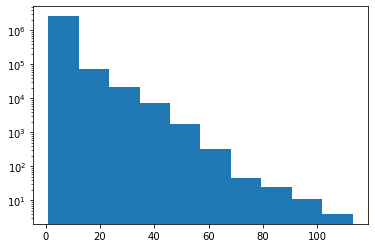

In [36]:
#Distribuição repetição feature "nameDest"

plt.hist(nameDest.value_counts().values)
plt.yscale('log')
plt.show()

In [37]:
nameDestF = pd.Series(df['nameDest'].loc[df['isFraud'] == 1].tolist())

print('Número de nameDest únicos - Fraude : ',np.unique(nameDestF).shape[0])

n = nameDestF.value_counts() > 1
print('Número de nameDest repetidos - Fraude : ',n[n].shape[0])

Número de nameDest únicos - Fraude :  8169
Número de nameDest repetidos - Fraude :  44


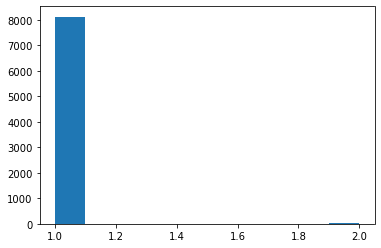

In [38]:
#Distribuição feature "nameDest" classificadas como fraude

plt.hist(nameDestF.value_counts().values)
plt.show()

Obs: Tanto a feature "nameOrig" como "nameDest" quando classificadas como não fraude (0) possuem tendência decrescente no quesito aparições únicas. Já quando marcadas como fraude (1) tendem a não se repetir.

### DATA PREPARATION

In [39]:
dfp = df.copy()

In [40]:
dfp.shape

(6362620, 11)

Nessa fase utilizarei os insights obtidos na etapa anterior e aplicarei diferentes técnicas (Dummy, Label Encoding e PCA) para preparar nossos dataframes para a fase de modelagem. Ao final dessa etapa, terei 4 diferentes dataframes. Um utilizando a técnica de dummy para a feature ("type") e a técnica de label encoding para as features  ("nameOrig, nameDest") e um utilizando a técnica label encoding para todas as features object. Também aplicarei o algorítmo de PCA em ambos dataframes gerando assim dois outros, totalizando os 4.  

#### DATAFRAME DUMMY + LABEL ENCODING

In [41]:
dfp_dummy = dfp.copy()

In [42]:
#Transformação da feature "type" através da técnica Dummy

dummy = pd.get_dummies(dfp_dummy[['type']])
dfp_dummy = pd.concat([dfp_dummy,dummy],axis = 1)

In [43]:
dfp_dummy.drop(labels='type', axis=1, inplace = True)

In [44]:
dfp_dummy.sample(5)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2222352,186,252525.72,C1581405581,0.00,0.00,C81349149,618693.23,871218.95,0,0,0,1,0,0,0
4466493,324,30600.24,C1082563569,0.00,0.00,C515132998,15320700.44,15351300.68,0,0,0,1,0,0,0
5360184,375,30673.10,C2009203226,0.00,0.00,M450312829,0.00,0.00,0,0,0,0,0,1,0
3301254,252,653236.40,C1756158898,11011.00,0.00,C745201352,0.00,617243.64,0,0,0,0,0,0,1
4216351,305,7007943.39,C6860810,10729.00,0.00,C232078007,1752343.39,8760286.78,0,0,0,0,0,0,1


In [45]:
dfp_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   nameOrig        object 
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   nameDest        object 
 6   oldbalanceDest  float64
 7   newbalanceDest  float64
 8   isFraud         int64  
 9   isFlaggedFraud  int64  
 10  type_CASH_IN    uint8  
 11  type_CASH_OUT   uint8  
 12  type_DEBIT      uint8  
 13  type_PAYMENT    uint8  
 14  type_TRANSFER   uint8  
dtypes: float64(5), int64(3), object(2), uint8(5)
memory usage: 515.8+ MB


In [46]:
# Transformação das features "nameOrig" e "nameDest" através da técnica Label Encoding

objList = dfp_dummy.select_dtypes(include = "object").columns

print (objList)

le = LabelEncoder()

for i in objList:
    
    dfp_dummy[i] = le.fit_transform(dfp_dummy[i].astype(str))

print (dfp_dummy.info())

Index(['nameOrig', 'nameDest'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   nameOrig        int32  
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   nameDest        int32  
 6   oldbalanceDest  float64
 7   newbalanceDest  float64
 8   isFraud         int64  
 9   isFlaggedFraud  int64  
 10  type_CASH_IN    uint8  
 11  type_CASH_OUT   uint8  
 12  type_DEBIT      uint8  
 13  type_PAYMENT    uint8  
 14  type_TRANSFER   uint8  
dtypes: float64(5), int32(2), int64(3), uint8(5)
memory usage: 467.2 MB
None


Após transformação das features, farei o teste de variance inflation factor VIF (fator de inflação de variância) que mede o quanto o comportamento de uma feature independente é influenciado, ou inflado, por sua interação/correlação com as demais features independentes também conhecido como multicolinearidade.

In [47]:
#Verificação de multicolinearidade

def calc_vif(df):

    vif = pd.DataFrame()
    vif["Features"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

#calc_vif(dfp_dummy)

Obs: Features "oldbalanceOrg" e "newbalanceOrig" / "oldbalanceDest"	e "newbalanceDest" possuem alto valor VIF. Nesse caso, verifiquei a feature com menor correlação com Y e a excluirei do dataframe. 

In [48]:
#Cópia do datraframe antes da exclusão das features para utilização na técnica PCA

df_pca_dummy = dfp_dummy.copy() 

In [49]:
#Features "newbalanceOrig" e "newbalanceDest" apresentaram menor valor de correlação com Y

dfp_dummy.drop(['newbalanceOrig','newbalanceDest'],axis=1, inplace = True)

In [50]:
#Normalização de escala das features "amount", "oldbalanceDest" e "oldbalanceOrg"

scaler = StandardScaler()

dfp_dummy["normAmount"] = scaler.fit_transform(dfp_dummy["amount"].values.reshape(-1, 1))
dfp_dummy["normOldbalanceDest"] = scaler.fit_transform(dfp_dummy["oldbalanceDest"].values.reshape(-1, 1))
dfp_dummy["normOldbalanceOrg"] = scaler.fit_transform(dfp_dummy["oldbalanceOrg"].values.reshape(-1, 1))

dfp_dummy.drop(['amount','oldbalanceDest','oldbalanceOrg'], inplace= True, axis= 1)

In [51]:
dfp_dummy.describe()

,step,nameOrig,nameDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,normAmount,normOldbalanceDest,normOldbalanceOrg
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,3176678.11,746427.04,0.00,0.00,0.22,0.35,0.01,0.34,0.08,0.00,-0.00,0.00
std,142.33,1834064.17,750245.52,0.04,0.00,0.41,0.48,0.08,0.47,0.28,1.00,1.00,1.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.30,-0.32,-0.29
25%,156.00,1588331.75,216895.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.28,-0.32,-0.29
50%,239.00,3176672.50,432289.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.17,-0.28,-0.28
75%,335.00,4765048.25,1132509.25,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.05,-0.05,-0.25
max,743.00,6353306.00,2722361.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,152.79,104.41,20.34


In [52]:
#Verificação de multicolinearidade

#calc_vif(dfp_dummy)

<AxesSubplot:>

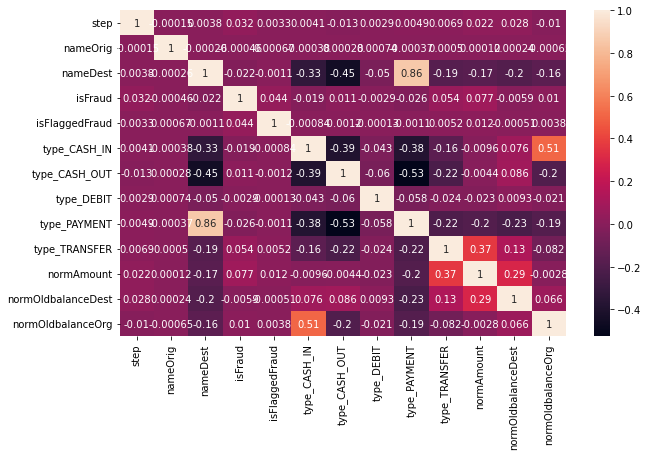

In [53]:
#Verificação de correlação

corr=dfp_dummy.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

Após os ajustes no dataframe, pude observar que a feature "nameOrig" possui a menor correlação com Y. E levando em consideração o insight obtido na fase de DATA UNDERSTANDING, optei por excluí-la do dataframe

In [54]:
dfp_dummy.drop(['nameOrig'],axis=1, inplace = True)

In [55]:
dfp_dummy.sample(5)

,step,nameDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,normAmount,normOldbalanceDest,normOldbalanceOrg
5084031,355,349125,0,0,0,0,1,0,0,-0.30,-0.18,-0.22
4293441,307,18569,0,0,0,1,0,0,0,-0.22,-0.07,-0.29
560242,22,993208,0,0,0,0,0,1,0,-0.27,-0.32,-0.19
255095,14,183194,0,0,0,1,0,0,0,-0.13,-0.28,-0.29
3328404,253,38940,0,0,1,0,0,0,0,0.33,0.34,-0.28


#### DATAFRAME LABEL ENCODING

In [56]:
dfp_le = dfp.copy()

In [57]:
dfp_le.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [58]:
#Transformação das features object através da técnica de Label Encoding

objList = dfp_le.select_dtypes(include = "object").columns

print (objList)

le = LabelEncoder()

for i in objList:
    
    dfp_le[i] = le.fit_transform(dfp_le[i].astype(str))

print (dfp_le.info())

Index(['type', 'nameOrig', 'nameDest'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB
None


In [59]:
#Verificação de multicolinearidade

#calc_vif(dfp_le)

Como os resultados do teste VIF através da técnica Label Encoding foram parecidos com os resultados obtidos dataframe anterior. Optei por seguir a mesma linha de raciocínio para tratar o dataframe.  

In [60]:
#Cópia do datraframe antes da exclusão das features para utilização na técnica PCA

df_pca_le = dfp_le.copy() 

In [61]:
#Features "newbalanceOrig" e "newbalanceDest" apresentaram menor valor de correlação com Y

dfp_le.drop(['newbalanceOrig','newbalanceDest'],axis=1, inplace = True)

In [62]:
#Normalização de escala das features "amount", "oldbalanceDest" e "oldbalanceOrg"

dfp_le["normAmount"] = scaler.fit_transform(dfp_le["amount"].values.reshape(-1, 1))
dfp_le["normOldbalanceDest"] = scaler.fit_transform(dfp_le["oldbalanceDest"].values.reshape(-1, 1))
dfp_le["normOldbalanceOrg"] = scaler.fit_transform(dfp_le["oldbalanceOrg"].values.reshape(-1, 1))

dfp_le.drop(['amount','oldbalanceDest','oldbalanceOrg'], inplace= True, axis= 1)

In [63]:
#Verificação de multicolinearidade

#calc_vif(dfp_le)

<AxesSubplot:>

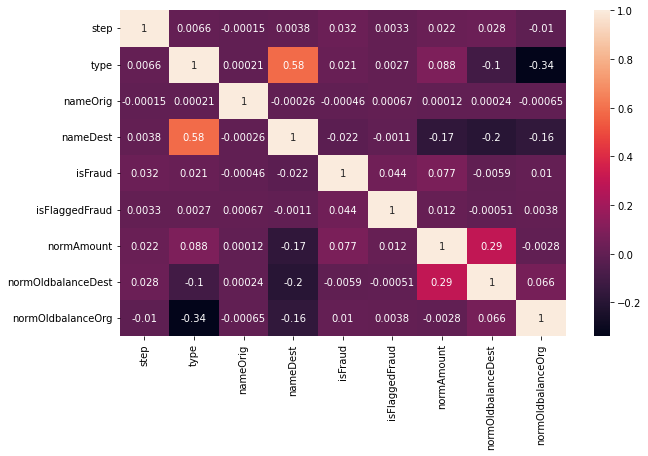

In [64]:
#Verificação de correlação

corr=dfp_le.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

Na mesma linha dos resultados obtidos no dataframe anterior, "nameOrig" possui menor correlação com Y. Optei pro excluí-la do dataframe.

In [65]:
dfp_le.drop(['nameOrig'],axis=1, inplace = True)

In [66]:
dfp_le.sample(5)

,step,type,nameDest,isFraud,isFlaggedFraud,normAmount,normOldbalanceDest,normOldbalanceOrg
6269311,619,3,1359662,0,0,-0.28,-0.32,-0.09
4576051,328,3,602449,0,0,-0.23,-0.32,-0.29
154473,12,1,467673,0,0,-0.01,0.16,-0.29
2924532,229,3,1677911,0,0,-0.27,-0.32,-0.28
4749967,333,1,394356,0,0,-0.02,1.52,-0.29


#### PCA DATAFRAME DUMMY + LABEL ENCODING

In [67]:
#Aplicação do algorítmo PCA no dataframe dummy

Y_dummy_pca = df_pca_dummy["isFraud"]
X_dummy_pca = df_pca_dummy.drop(["isFraud","isFlaggedFraud"], axis= 1)

dummy_pca = PCA(n_components=0.95)

pca = dummy_pca.fit_transform(X_dummy_pca)

df_pca = pd.DataFrame(data = pca)

dfp_pca_dummy = pd.concat([df_pca, Y_dummy_pca], axis = 1)

dfp_pca_dummy.sample(5)

,0,1,2,isFraud
5525191,-1825549.35,-957544.62,-2353685.67,0
5527787,-523838.54,6660983.67,-2385263.70,0
181692,-877055.02,-1069704.46,1812309.34,0
4972192,-545141.57,-1111474.90,-1569538.71,0
1642912,-1800274.19,-658184.89,955735.32,0


#### PCA DATAFRAME LABEL ENCODING

In [68]:
#Aplicação do algorítmo PCA no dataframe Label Encoding

Y_le_pca = df_pca_le["isFraud"]
X_le_pca = df_pca_le.drop(["isFraud","isFlaggedFraud"], axis= 1)

le_pca = PCA(n_components=0.95)

pca = le_pca.fit_transform(X_le_pca)

df_pca = pd.DataFrame(data = pca)

dfp_pca_le = pd.concat([df_pca, Y_le_pca], axis = 1)

dfp_pca_le.sample(5)

,0,1,2,isFraud
209261,645425.82,-1185998.88,858080.81,0
542991,-1862443.35,-983321.36,3039656.82,0
926123,-1201039.17,-1013422.82,1427942.06,0
1655030,-1798205.36,-955652.46,-909478.09,0
2645040,3050799.31,-1613183.21,1346175.82,0


### MODELING

Nesta etapa irei utilizar os 4 dataframes gerados na fase anterior para treinar os algoritmos de Machine Learning (Decision Tree, Random Forest e XGBoost) 

In [69]:
#Divisão dos dataframes entre features dependentes e independente

Y_dummy = dfp_dummy["isFraud"]
X_dummy = dfp_dummy.drop(["isFraud"], axis= 1)

Y_le = dfp_le["isFraud"]
X_le = dfp_le.drop(["isFraud"], axis= 1)

Y_pca_dummy = dfp_pca_dummy["isFraud"]
X_pca_dummy = dfp_pca_dummy.drop(["isFraud"], axis= 1)

Y_pca_le = dfp_pca_le["isFraud"]
X_pca_le = dfp_pca_le.drop(["isFraud"], axis= 1)

In [70]:
#Divisão do dataframe dummy entre treino e teste

(X_train_dummy, X_test_dummy, Y_train_dummy, Y_test_dummy) = train_test_split(X_dummy, Y_dummy, test_size= 0.3, random_state= 42)

print("X_train_dummy: ", X_train_dummy.shape)
print("X_test_dummy: ", X_test_dummy.shape)

X_train_dummy:  (4453834, 11)
X_test_dummy:  (1908786, 11)


In [71]:
#Divisão do dataframe label encoding entre treino e teste

(X_train_le, X_test_le, Y_train_le, Y_test_le) = train_test_split(X_le, Y_le, test_size= 0.3, random_state= 42)

print("X_train_le: ", X_train_le.shape)
print("X_test_le: ", X_test_le.shape)

X_train_le:  (4453834, 7)
X_test_le:  (1908786, 7)


In [72]:
#Divisão do dataframe pca dummy entre treino e teste

(X_train_pca_dummy, X_test_pca_dummy, Y_train_pca_dummy, Y_test_pca_dummy) = train_test_split(X_pca_dummy, Y_pca_dummy, test_size= 0.3, random_state= 42)

print("X_train_pca_dummy: ", X_train_pca_dummy.shape)
print("X_test_pca_dummy: ", X_test_pca_dummy.shape)

X_train_pca_dummy:  (4453834, 3)
X_test_pca_dummy:  (1908786, 3)


In [73]:
#Divisão do dataframe pca label encoding entre treino e teste

(X_train_pca_le, X_test_pca_le, Y_train_pca_le, Y_test_pca_le) = train_test_split(X_pca_le, Y_pca_le, test_size= 0.3, random_state= 42)

print("X_train_pca_le: ", X_train_pca_le.shape)
print("X_test_pca_le: ", X_test_pca_le.shape)

X_train_pca_le:  (4453834, 3)
X_test_pca_le:  (1908786, 3)


#### DECISION TREE

###### DUMMY

In [74]:
%%time

dt_d = DecisionTreeClassifier()

dt_d.fit(X_train_dummy, Y_train_dummy)

Y_pred_dt_dummy = dt_d.predict(X_test_dummy)

dt_score_dummy = dt_d.score(X_test_dummy, Y_test_dummy) * 100

print("Decision Tree Dummy Score: ", dt_score_dummy)

Decision Tree Dummy Score:  99.93000786887582
CPU times: total: 1min 33s
Wall time: 1min 36s


##### LABEL ENCODING

In [75]:
%%time

dt_le = DecisionTreeClassifier()

dt_le.fit(X_train_le, Y_train_le)

Y_pred_dt_le = dt_le.predict(X_test_le)

dt_score_le = dt_le.score(X_test_le, Y_test_le) * 100

print("Decision Tree Label Enconding Score: ", dt_score_le)

Decision Tree Label Enconding Score:  99.92953636499848
CPU times: total: 1min 49s
Wall time: 1min 55s


###### PCA DUMMY

In [76]:
%%time

dt_pca_d = DecisionTreeClassifier()

dt_pca_d.fit(X_train_pca_dummy, Y_train_pca_dummy)

Y_pred_dt_pca_dummy = dt_pca_d.predict(X_test_pca_dummy)

dt_score_pca_dummy = dt_pca_d.score(X_test_pca_dummy, Y_test_pca_dummy) * 100

print("Decision Tree PCA Dummy Score: ", dt_score_pca_dummy)

Decision Tree PCA Dummy Score:  99.75057444889055
CPU times: total: 1min 45s
Wall time: 1min 48s


##### PCA LABEL ENCODING

In [77]:
%%time

dt_pca_le = DecisionTreeClassifier()

dt_pca_le.fit(X_train_pca_le, Y_train_pca_le)

Y_pred_dt_pca_le = dt_pca_le.predict(X_test_pca_le)

dt_score_pca_le = dt_pca_le.score(X_test_pca_le, Y_test_pca_le) * 100

print("Decision Tree PCA Label Enconding Score: ", dt_score_pca_le)

Decision Tree PCA Label Enconding Score:  99.75204134984226
CPU times: total: 1min 47s
Wall time: 1min 55s


#### RANDOM FOREST

##### DUMMY

In [ ]:
%%time

rf_d = RandomForestClassifier(n_estimators= 100) 

rf_d.fit(X_train_dummy, Y_train_dummy)

Y_pred_rf_dummy = rf_d.predict(X_test_dummy)

rf_score_dummy = rf_d.score(X_test_dummy, Y_test_dummy) * 100

print("Random Forest Dummy Score: ", rf_score_dummy)

##### LABEL ENCODING

In [ ]:
%%time

rf_le = RandomForestClassifier(n_estimators= 100)

rf_le.fit(X_train_le, Y_train_le)

Y_pred_rf_le = rf_le.predict(X_test_le)

rf_score_le = rf_le.score(X_test_le, Y_test_le) * 100

print("Random Forest Label Encoding Score: ", rf_score_le)

##### PCA DUMMMY

In [ ]:
%%time

rf_pca_d = RandomForestClassifier(n_estimators= 100)

rf_pca_d.fit(X_train_pca_dummy, Y_train_pca_dummy)

Y_pred_rf_pca_dummy = rf_pca_d.predict(X_test_pca_dummy)

rf_score_pca_dummy = rf_pca_d.score(X_test_pca_dummy, Y_test_pca_dummy) * 100

print("Random Forest PCA Dummy Score: ", rf_score_pca_dummy)

##### PCA LABEL ENCODING

In [ ]:
%%time

rf_pca_le = RandomForestClassifier(n_estimators= 100)

rf_pca_le.fit(X_train_pca_le, Y_train_pca_le)

Y_pred_rf_pca_le = rf_pca_le.predict(X_test_pca_le)

rf_score_pca_le = rf_pca_le.score(X_test_pca_le, Y_test_pca_le) * 100

print("Random Forest Label PCA Encoding Score: ", rf_score_pca_le)

#### XGBOOST

##### DUMMY

In [ ]:
%%time

xgb_dummy  = xgb.XGBClassifier()

xgb_dummy.fit(X_train_dummy, Y_train_dummy)

Y_pred_xgb_dummy = xgb_dummy.predict(X_test_dummy)

xgb_score_dummy = xgb_dummy.score(X_test_dummy, Y_test_dummy)*100

print("XGBOOST Dummy Score: ", xgb_score_dummy)

##### LABEL ENCODING

In [ ]:
%%time

xgb_le  = xgb.XGBClassifier()

xgb_le.fit(X_train_le, Y_train_le)

Y_pred_xgb_le = xgb_le.predict(X_test_le)

xgb_score_le = xgb_le.score(X_test_le, Y_test_le)*100

print("XGBOOST Label Encoding Score: ", xgb_score_le)

##### PCA DUMMY

In [ ]:
%%time

xgb_pca_dummy  = xgb.XGBClassifier()

xgb_pca_dummy.fit(X_train_pca_dummy, Y_train_pca_dummy)

Y_pred_xgb_pca_dummy = xgb_pca_dummy.predict(X_test_pca_dummy)

xgb_score_pca_dummy = xgb_pca_dummy.score(X_test_pca_dummy, Y_test_pca_dummy)*100

print("XGBOOST PCA Dummy Score: ", xgb_score_pca_dummy)

##### PCA LABEL ENCODING

In [ ]:
%%time

xgb_pca_le  = xgb.XGBClassifier()

xgb_pca_le.fit(X_train_pca_le, Y_train_pca_le)

Y_pred_xgb_pca_le = xgb_pca_le.predict(X_test_pca_le)

xgb_score_pca_le = xgb_pca_le.score(X_test_pca_le, Y_test_pca_le)*100

print("XGBOOST PCA Label Encoding Score: ", xgb_score_pca_le)

### EVALUATION

Nesta etapa irei levantar os indicadores de desempenho dos algoritmos com cada um dos dataframes para posterior comparação.

In [ ]:
#Matriz de confusão

print("##############################")
print("TP,FP,TN,FN - Decision Tree - Base Dummy")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_dummy, Y_pred_dt_dummy).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("------------------------------")
print("TP,FP,TN,FN - Decision Tree - Base Label Encoding")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_le, Y_pred_dt_le).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("------------------------------")
print("TP,FP,TN,FN - Decision Tree - PCA - Base Dummy")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_pca_dummy, Y_pred_dt_pca_dummy).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("------------------------------")
print("TP,FP,TN,FN - Decision Tree - PCA - Base Label Encoding")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_pca_le, Y_pred_dt_pca_le).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("##############################")
print("TP,FP,TN,FN - Random Forest - Base Dummy")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_dummy, Y_pred_rf_dummy).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("------------------------------")
print("TP,FP,TN,FN - Random Forest - Base Label Encoding")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_le, Y_pred_rf_le).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("------------------------------")
print("TP,FP,TN,FN - Random Forest - PCA - Base Dummy")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_pca_dummy, Y_pred_rf_pca_dummy).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("------------------------------")
print("TP,FP,TN,FN - Random Forest - PCA - Base Label Encoding")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_pca_le, Y_pred_rf_pca_le).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("##############################")
print("TP,FP,TN,FN - XGBoost - Base Dummy")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_dummy, Y_pred_xgb_dummy).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("------------------------------")
print("TP,FP,TN,FN - XGBoost - Base Label Encoding")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_le, Y_pred_xgb_le).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("------------------------------")
print("TP,FP,TN,FN - XGBoost - PCA - Base Dummy")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_pca_dummy, Y_pred_xgb_pca_dummy).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("------------------------------")
print("TP,FP,TN,FN - XGBoost - PCA - Base Label Encoding")
print("..............................")

tn, fp, fn, tp = confusion_matrix(Y_test_pca_le, Y_pred_xgb_pca_le).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

In [ ]:
# Gráfico para matriz de confusão Decision Tree 

confusion_matrix_dt_dummy = confusion_matrix(Y_test_dummy, Y_pred_dt_dummy.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt_dummy)
disp.plot()
plt.title('Confusion Matrix - DT - Dummy')
plt.show()

confusion_matrix_dt_le = confusion_matrix(Y_test_le, Y_pred_dt_le.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt_le)
disp.plot()
plt.title('Confusion Matrix - DT - Label Encoding')
plt.show()

confusion_matrix_dt_pca_dummy = confusion_matrix(Y_test_pca_dummy, Y_pred_dt_pca_dummy.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt_pca_dummy)
disp.plot()
plt.title('Confusion Matrix - DT - PCA - Dummy')
plt.show()

confusion_matrix_dt_pca_le = confusion_matrix(Y_test_pca_le, Y_pred_dt_pca_le.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt_pca_le)
disp.plot()
plt.title('Confusion Matrix - DT - PCA - Label Encoding')
plt.show()

In [ ]:
# Gráfico para matriz de confusão Random Forest

confusion_matrix_rf_dummy = confusion_matrix(Y_test_dummy, Y_pred_rf_dummy.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf_dummy)
disp.plot()
plt.title('Confusion Matrix - RF - Dummy')
plt.show()

confusion_matrix_rf_le = confusion_matrix(Y_test_le, Y_pred_rf_le.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf_le)
disp.plot()
plt.title('Confusion Matrix - RF - Label Encoding')
plt.show()

confusion_matrix_rf_pca_dummy = confusion_matrix(Y_test_pca_dummy, Y_pred_rf_pca_dummy.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf_pca_dummy)
disp.plot()
plt.title('Confusion Matrix - RF - PCA - Dummy')
plt.show()

confusion_matrix_rf_pca_le = confusion_matrix(Y_test_pca_le, Y_pred_rf_pca_le.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf_pca_le)
disp.plot()
plt.title('Confusion Matrix - RF - PCA - Label Encoding')
plt.show()

In [ ]:
# Gráfico para matriz de confusão XGBoost 

confusion_matrix_xgb_dummy = confusion_matrix(Y_test_dummy, Y_pred_xgb_dummy.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_xgb_dummy)
disp.plot()
plt.title('Confusion Matrix - XGB - Dummy')
plt.show()

confusion_matrix_xgb_le = confusion_matrix(Y_test_le, Y_pred_xgb_le.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_xgb_le)
disp.plot()
plt.title('Confusion Matrix - XGB - Label Encoding')
plt.show()

confusion_matrix_xgb_pca_dummy = confusion_matrix(Y_test_pca_dummy, Y_pred_xgb_pca_dummy.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_xgb_pca_dummy)
disp.plot()
plt.title('Confusion Matrix - XGB - PCA - Dummy')
plt.show()

confusion_matrix_xgb_pca_le = confusion_matrix(Y_test_pca_le, Y_pred_xgb_pca_le.round())

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_xgb_pca_le)
disp.plot()
plt.title('Confusion Matrix - XGB - PCA - Label Encoding')
plt.show()

In [ ]:
# Indicador F1-Score

classification_report_dt_dummy = classification_report(Y_test_dummy, Y_pred_dt_dummy)
print("Classification Report - Decision Tree - Base Dummy")
print(classification_report_dt_dummy)

print("----------------------------------------------------------------------------------------")

classification_report_dt_le = classification_report(Y_test_le, Y_pred_dt_le)
print("Classification Report - Decision Tree - Base Label Encoding")
print(classification_report_dt_le)

print("----------------------------------------------------------------------------------------")

classification_report_dt_pca_dummy = classification_report(Y_test_pca_dummy, Y_pred_dt_pca_dummy)
print("Classification Report - Decision Tree - PCA - Base Dummy")
print(classification_report_dt_pca_dummy)

print("----------------------------------------------------------------------------------------")

classification_report_dt_pca_le = classification_report(Y_test_pca_le, Y_pred_dt_pca_le)
print("Classification Report - Decision Tree - PCA - Base Label Encoding")
print(classification_report_dt_pca_le)

print("#######################################################################################")

classification_report_rf_dummy = classification_report(Y_test_dummy, Y_pred_rf_dummy)
print("Classification Report - Random Forest - Dummy")
print(classification_report_rf_dummy)

print("----------------------------------------------------------------------------------------")

classification_report_rf_le = classification_report(Y_test_le, Y_pred_rf_le)
print("Classification Report - Random Forest - Base Label Encoding")
print(classification_report_rf_le)

print("----------------------------------------------------------------------------------------")

classification_report_rf_pca_dummy = classification_report(Y_test_pca_dummy, Y_pred_rf_pca_dummy)
print("Classification Report - Random Forest - PCA - Dummy")
print(classification_report_rf_pca_dummy)

print("----------------------------------------------------------------------------------------")

classification_report_rf_pca_le = classification_report(Y_test_pca_le, Y_pred_rf_pca_le)
print("Classification Report - Random Forest - PCA - Base Label Encoding")
print(classification_report_rf_pca_le)

print("#######################################################################################")

classification_report_xgb_dummy = classification_report(Y_test_dummy, Y_pred_xgb_dummy)
print("Classification Report - XGBoost - Dummy")
print(classification_report_xgb_dummy)

print("----------------------------------------------------------------------------------------")

classification_report_xgb_le = classification_report(Y_test_le, Y_pred_xgb_le)
print("Classification Report - XGBoost - Base Label Encoding")
print(classification_report_xgb_le)

print("----------------------------------------------------------------------------------------")

classification_report_xgb_pca_dummy = classification_report(Y_test_pca_dummy, Y_pred_xgb_pca_dummy)
print("Classification Report - XGBoost - PCA - Dummy")
print(classification_report_xgb_pca_dummy)

print("----------------------------------------------------------------------------------------")

classification_report_xgb_pca_le = classification_report(Y_test_pca_le, Y_pred_xgb_pca_le)
print("Classification Report - XGBoost - PCA - Base Label Encoding")
print(classification_report_xgb_pca_le)

In [ ]:
# Gráfico curva ROC Decision Tree 

fpr, tpr, threshold = metrics.roc_curve(Y_test_dummy, Y_pred_dt_dummy)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT - Dummy')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

fpr, tpr, threshold = metrics.roc_curve(Y_test_le, Y_pred_dt_le)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT - Label Encoding')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

fpr, tpr, threshold = metrics.roc_curve(Y_test_pca_dummy, Y_pred_dt_pca_dummy)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT - PCA - Dummy')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

fpr, tpr, threshold = metrics.roc_curve(Y_test_pca_le, Y_pred_dt_pca_le)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT - PCA - Label Encoding')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Gráfico curva ROC Random Forest

fpr, tpr, threshold = metrics.roc_curve(Y_test_dummy, Y_pred_rf_dummy)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF - Dummy')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

fpr, tpr, threshold = metrics.roc_curve(Y_test_le, Y_pred_rf_le)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF - Label Encoding')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

fpr, tpr, threshold = metrics.roc_curve(Y_test_pca_dummy, Y_pred_rf_pca_dummy)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF - PCA - Dummy')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

fpr, tpr, threshold = metrics.roc_curve(Y_test_pca_le, Y_pred_rf_pca_le)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF - PCA - Label Encoding')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Gráfico curva ROC XGBoost

fpr, tpr, threshold = metrics.roc_curve(Y_test_dummy, Y_pred_xgb_dummy)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - XGB - Dummy')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

fpr, tpr, threshold = metrics.roc_curve(Y_test_le, Y_pred_xgb_le)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - XGB - Label Encoding')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

fpr, tpr, threshold = metrics.roc_curve(Y_test_pca_dummy, Y_pred_xgb_pca_dummy)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - XGB - PCA - Dummy')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

fpr, tpr, threshold = metrics.roc_curve(Y_test_pca_le, Y_pred_xgb_pca_le)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - XGB - PCA - Label Encoding')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()